# Can you estimate the age of an abalone?

## 📖 Background
You are working as an intern for an abalone farming operation in Japan. For operational and environmental reasons, it is an important consideration to estimate the age of the abalones when they go to market. 

Determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope. Since this method is somewhat cumbersome and complex, you are interested in helping the farmers estimate the age of the abalone using its physical characteristics.

![title](img/images.jpg)

In [1]:
# dependencies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as XGB
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, confusion_matrix
from sklearn.model_selection import cross_val_score

## 💾 The data
You have access to the following historical data ([source](https://archive.ics.uci.edu/ml/datasets/abalone)):

#### Abalone characteristics:
- "sex" - M, F, and I (infant).
- "length" - longest shell measurement.
- "diameter" - perpendicular to the length.
- "height" - measured with meat in the shell.
- "whole_wt" - whole abalone weight.
- "shucked_wt" - the weight of abalone meat.
- "viscera_wt" - gut-weight.
- "shell_wt" - the weight of the dried shell.
- "rings" - number of rings in a shell cross-section.
- "age" - the age of the abalone: the number of rings + 1.5.

***Acknowledgments**: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn, and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288).*

In [2]:
abalone = pd.read_csv('./data/abalone.csv')
display(abalone)

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,8.5
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,12.5
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,11.5
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.5
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.5


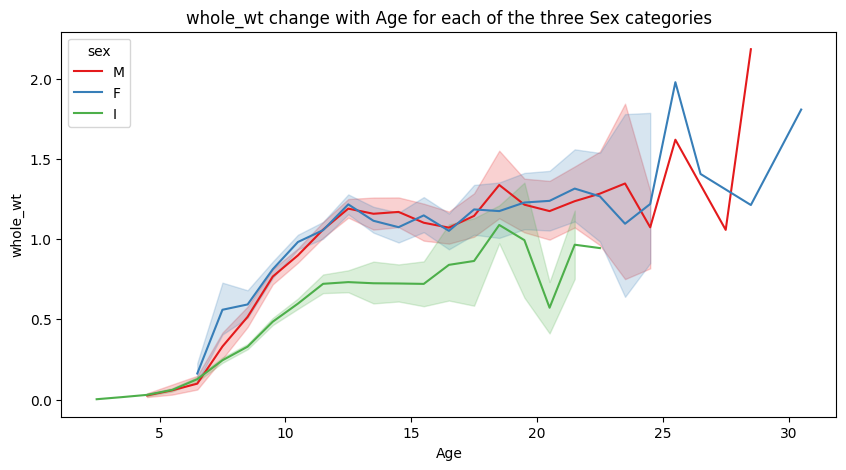

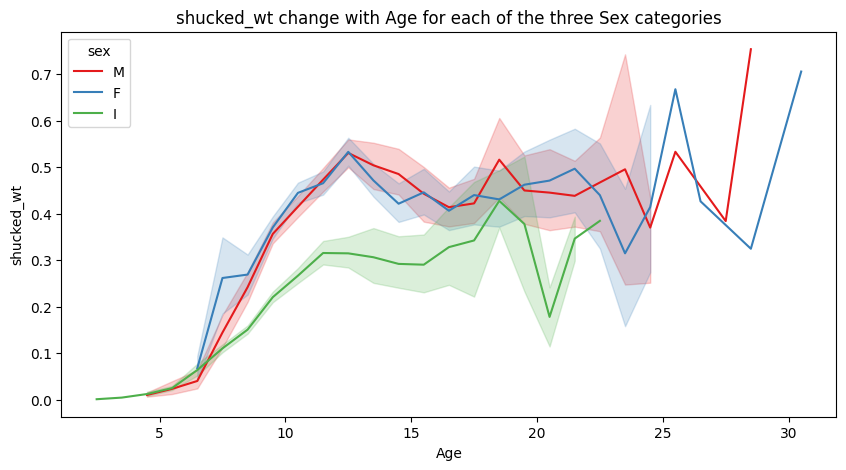

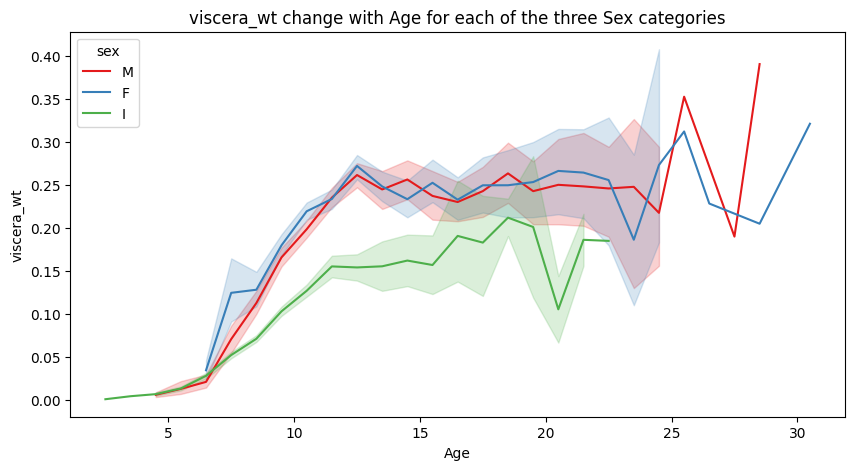

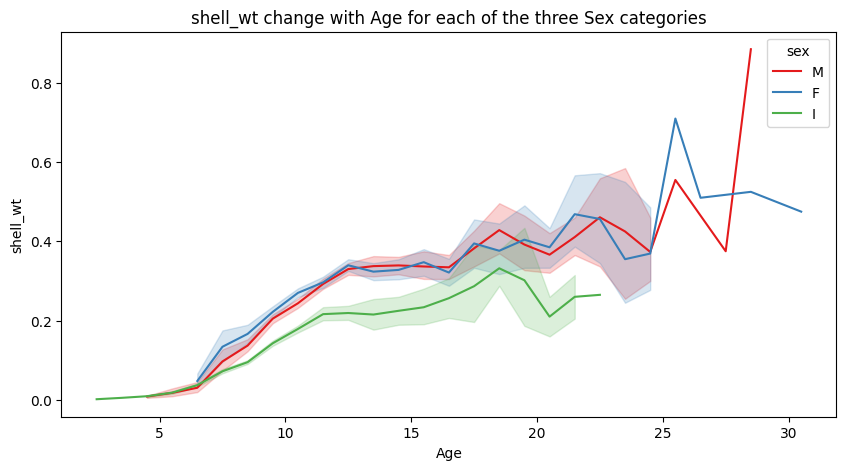

In [3]:
for weight in abalone.iloc[:, 4:8]:
    plt.figure(figsize=(10,5))
    sns.lineplot(data=abalone, x='age', y=weight, hue='sex', palette='Set1')
    plt.title('{} change with Age for each of the three Sex categories'.format(weight))
    plt.xlabel('Age')
    plt.ylabel(weight)
    plt.show()

### Data Engeneering.

For reduce the amount of features, we could combine the size metrics into single approximate volumes feature:<br>
<br>
$$ Abalone \ approximate \ Volume = \ 4/3 \ * \ \ Pi \ * \ \ ( \ Length \ * \ \ Height \ \ * \ \ Diameter \ ) \ $$ 

In [4]:
abalone['volume'] = (4/3)*np.pi*((abalone['length']*abalone['height']*abalone['diameter']))
display(abalone[['length', 'diameter', 'height', 'volume']])

,length,diameter,height,volume
0,0.455,0.365,0.095,0.066087
1,0.350,0.265,0.090,0.034966
2,0.530,0.420,0.135,0.125877
3,0.440,0.365,0.125,0.084090
4,0.330,0.255,0.080,0.028199
...,...,...,...,...
4172,0.565,0.450,0.165,0.175725
4173,0.590,0.440,0.135,0.146800
4174,0.600,0.475,0.205,0.244730
4175,0.625,0.485,0.150,0.190459


### Encoding with Label Encoder

In [5]:
le = LabelEncoder()
abalone['sex_enc'] = le.fit_transform(abalone['sex'])
display(abalone.head())
abalone_enc=abalone.drop('sex', axis=1)
abalone_enc['sex_enc'] = abalone_enc['sex_enc'].replace(2, 3).replace(0, 2)
display(abalone_enc.head())

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age,volume,sex_enc
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5,0.066087,2
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0.034966,2
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,0.125877,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,0.084090,2
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,0.028199,1


,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age,volume,sex_enc
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5,0.066087,3
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0.034966,3
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,0.125877,2
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,0.084090,3
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,0.028199,1


In [6]:
op_data = abalone_enc.drop(["rings", "shucked_wt", "viscera_wt", "shell_wt"], axis=1)

### Observing

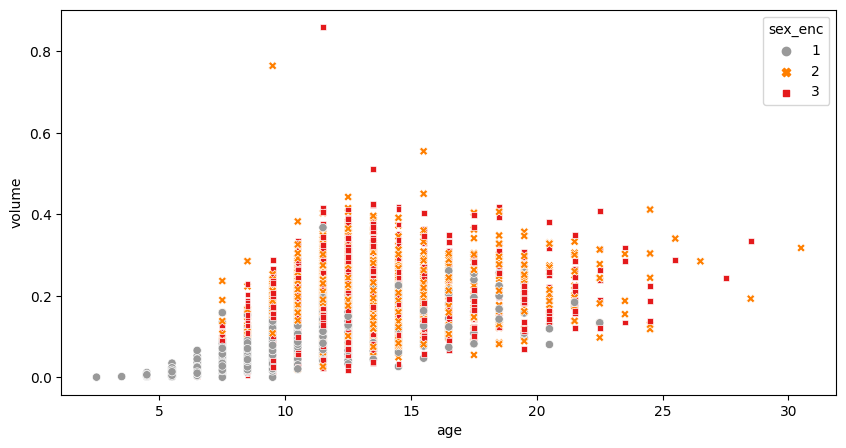

In [7]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=op_data, x='age', y='volume', hue='sex_enc', style='sex_enc', palette='Set1_r')
plt.show()

Male      1528
Infant    1342
Female    1307
Name: sex_enc, dtype: int64


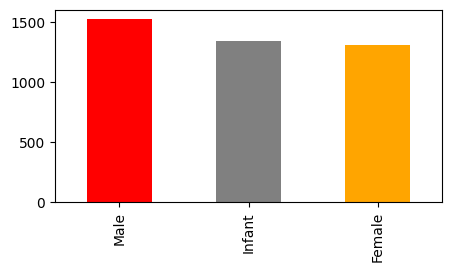

In [8]:
plt.figure(figsize=(5,2.5))
sex_count = op_data.sex_enc.value_counts()
#print(sex_count)
sex_count.index = ['Male', 'Infant', 'Female']
sex_count.plot(kind='bar', color=['red', 'gray', 'orange'])
print(sex_count)
plt.show()

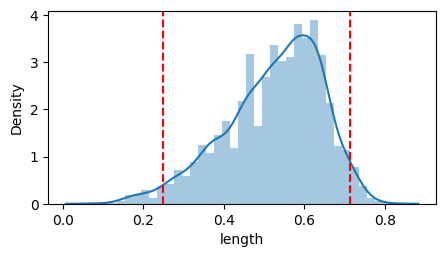

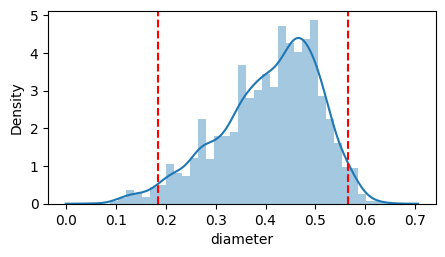

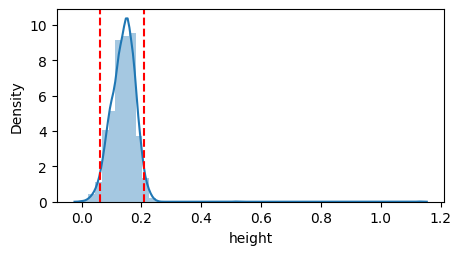

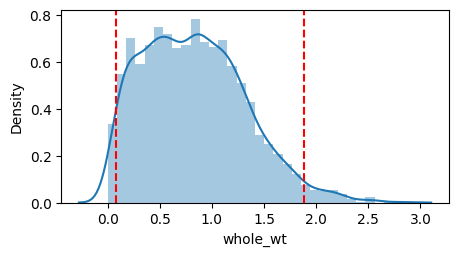

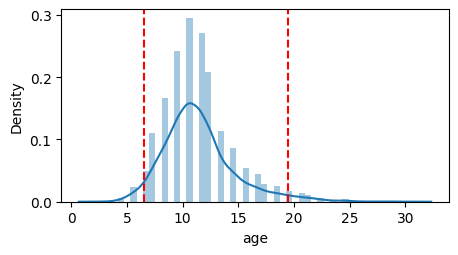

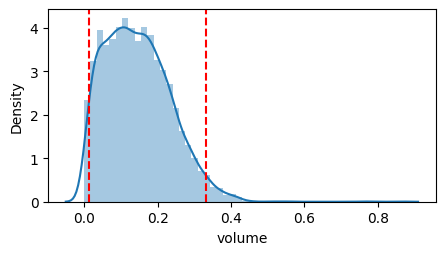

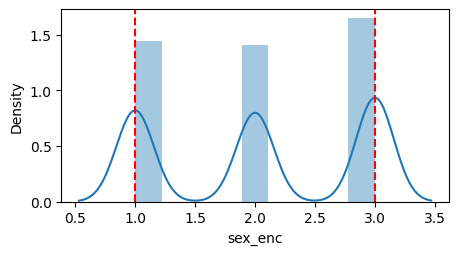

In [9]:
for x in op_data:
    plt.figure(figsize=(5,2.5))
    sns.distplot(op_data[x])
    plt.axvline(x = np.percentile(op_data[x], 2.5), color = 'r', linestyle = '--')
    plt.axvline(x = np.percentile(op_data[x], 97.5), color = 'r', linestyle = '--')
    plt.show()

In [10]:
print(np.percentile(op_data['age'], 2.5), np.percentile(op_data['age'], 97.5))
print(np.percentile(op_data['length'], 2.5), np.percentile(op_data['length'], 97.5))
print(np.percentile(op_data['diameter'], 2.5), np.percentile(op_data['diameter'], 97.5))
print(np.percentile(op_data['height'], 2.5), np.percentile(op_data['height'], 97.5))
print(np.percentile(op_data['whole_wt'], 2.5), np.percentile(op_data['whole_wt'], 97.5))

6.5 19.5
0.25 0.715
0.185 0.565
0.06 0.21
0.0787 1.885


### Taking confidence interval

The diameter's 2.5th percentile:  0.185 , and 97.5th percentile:  0.565


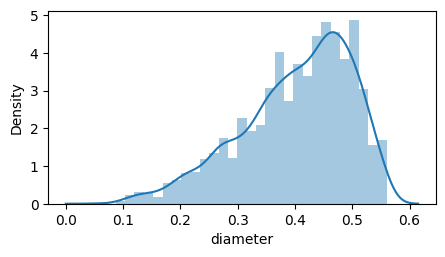

Non-missing data in diameter:  4055 

The height's 2.5th percentile:  0.06 , and 97.5th percentile:  0.21


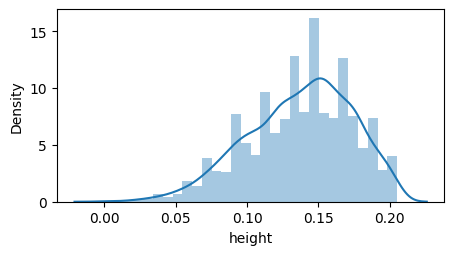

Non-missing data in height:  4068 

The whole_wt's 2.5th percentile:  0.0787 , and 97.5th percentile:  1.885


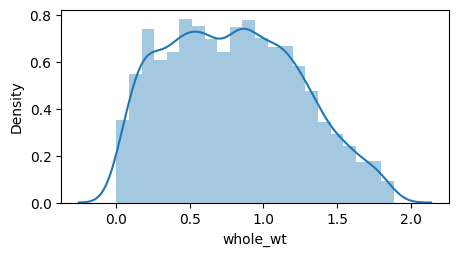

Non-missing data in whole_wt:  4071 

The age's 2.5th percentile:  6.5 , and 97.5th percentile:  19.5


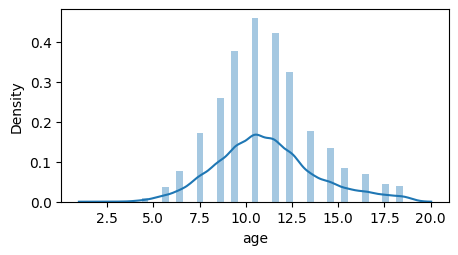

Non-missing data in age:  4041 

The volume's 2.5th percentile:  0.012007167122020188 , and 97.5th percentile:  0.33317061330217795


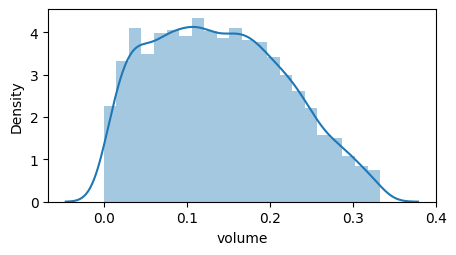

Non-missing data in volume:  4072 



In [11]:
for x in op_data.iloc[:, 1:-1]:
    xishe = op_data[x]
    pl = np.percentile(xishe, 2.5)
    ph = np.percentile(xishe, 97.5)
    print("The {}'s 2.5th percentile: ".format(x), pl, ", and 97.5th percentile: ", ph)
    op_data[x] = xishe[xishe > pl]
    op_data[x] = xishe[xishe < ph]
    plt.figure(figsize=(5,2.5))
    sns.distplot(op_data[x])
    plt.show()
    print("Non-missing data in {}: ".format(x), op_data[x].notna().sum(), '\n')

### Dealing with missing data

In [12]:
print(op_data.isna().sum())
print(op_data.notna().sum())
op_data_d = op_data.dropna()
print('\nData shape after the dropping a missing data is:\n', op_data_d.notna().sum())

length        0
diameter    122
height      109
whole_wt    106
age         136
volume      105
sex_enc       0
dtype: int64
length      4177
diameter    4055
height      4068
whole_wt    4071
age         4041
volume      4072
sex_enc     4177
dtype: int64

Data shape after the dropping a missing data is:
 length      3850
diameter    3850
height      3850
whole_wt    3850
age         3850
volume      3850
sex_enc     3850
dtype: int64


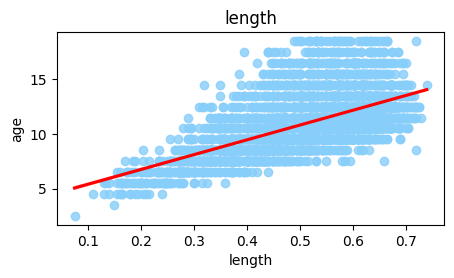

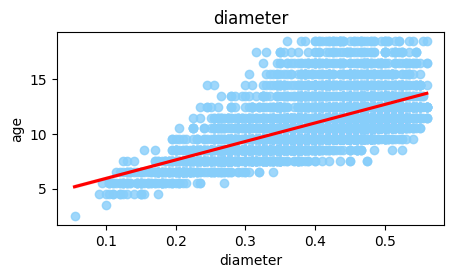

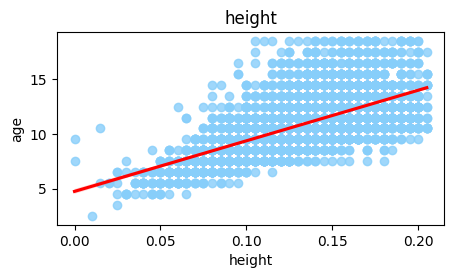

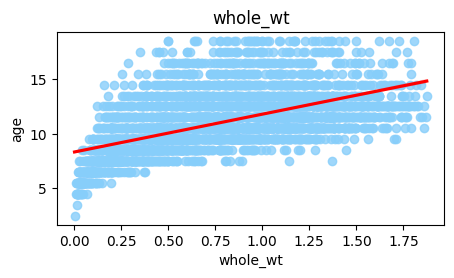

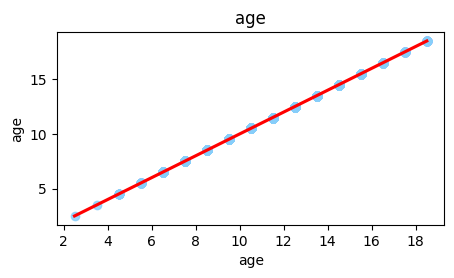

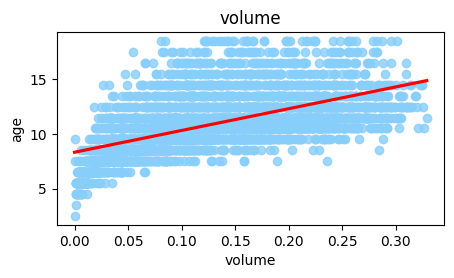

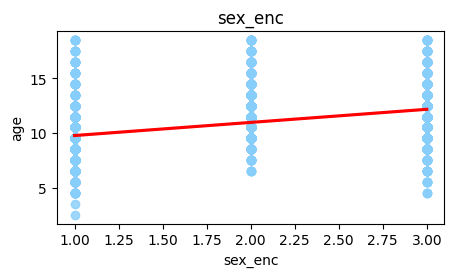

In [13]:
for x in op_data_d:
    plt.figure(figsize=(5,2.5))
    sns.regplot(data=op_data_d, x=x, y='age', scatter_kws={"color": "lightskyblue"}, line_kws={"color": "red"})
    plt.title(x)
    plt.show()

Male      1373
Infant    1330
Female    1147
Name: sex_enc, dtype: int64


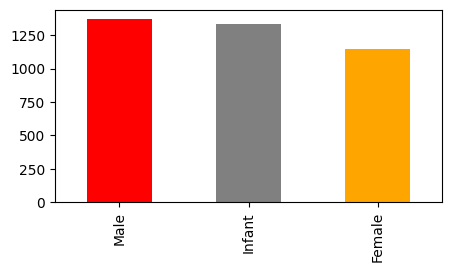

In [14]:
plt.figure(figsize=(5,2.5))
sex_count = op_data_d.sex_enc.value_counts()
sex_count.index = ['Male', 'Infant', 'Female']
sex_count.plot(kind='bar', color=['red', 'gray', 'orange'])
print(sex_count)
plt.show()

### Observing combined and separated sexes data

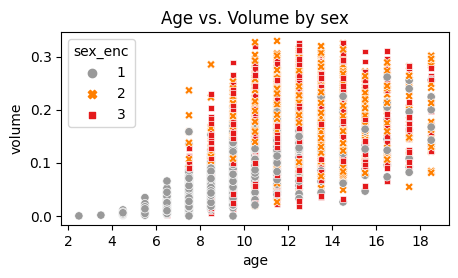

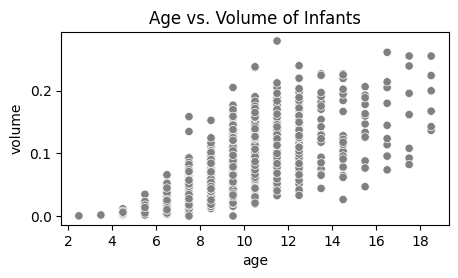

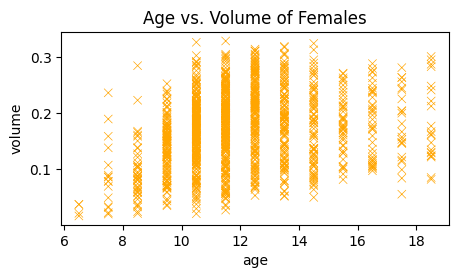

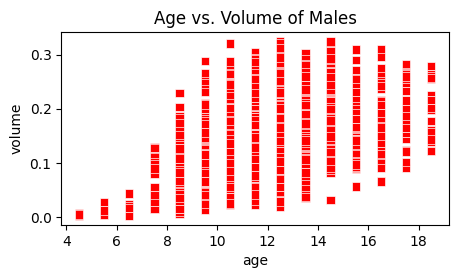

In [15]:
plt.figure(figsize=(5,2.5))
sns.scatterplot(data=op_data_d, x='age', y='volume', hue='sex_enc', style='sex_enc', palette='Set1_r')
plt.title('Age vs. Volume by sex')
plt.show()

plt.figure(figsize=(5,2.5))
data_sex1 = op_data_d[op_data_d['sex_enc'] == 1]
sns.scatterplot(data=data_sex1, x='age', y='volume', hue='sex_enc', palette=['gray'], legend=None)
plt.title('Age vs. Volume of Infants')
plt.show()

plt.figure(figsize=(5,2.5))
data_sex2 = op_data_d[op_data_d['sex_enc'] == 2]
sns.scatterplot(data=data_sex2, x='age', y='volume', hue='sex_enc', palette=['orange'], marker='x', legend=None)
plt.title('Age vs. Volume of Females')
plt.show()

plt.figure(figsize=(5,2.5))
data_sex3 = op_data_d[op_data_d['sex_enc'] == 3]
sns.scatterplot(data=data_sex3, x='age', y='volume', hue='sex_enc', palette=['red'], marker='s', legend=None)
plt.title('Age vs. Volume of Males')
plt.show()

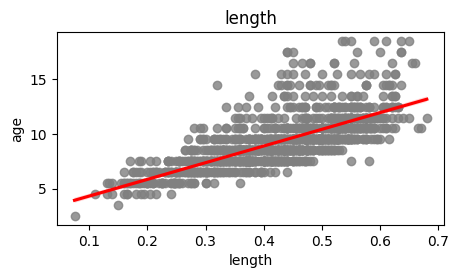

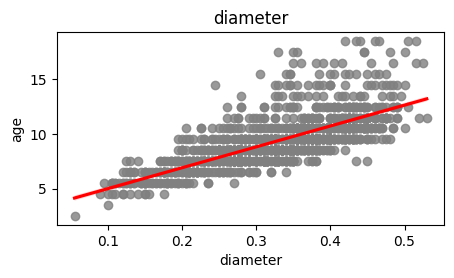

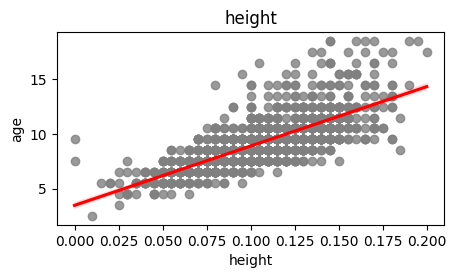

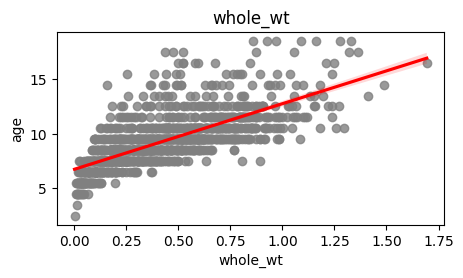

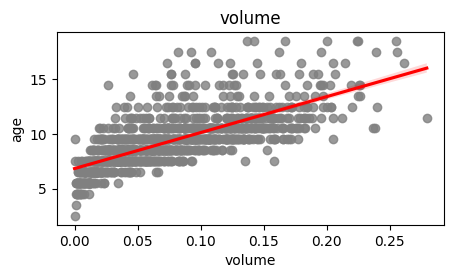

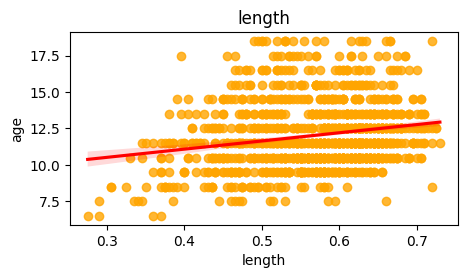

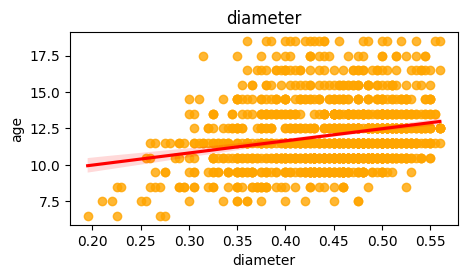

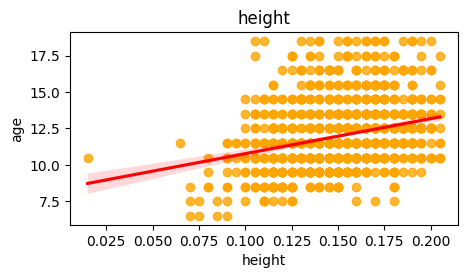

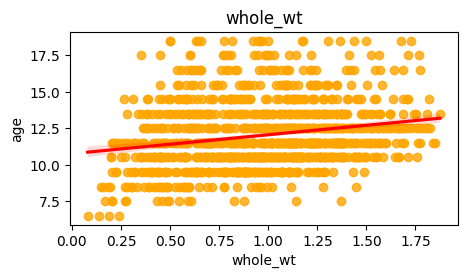

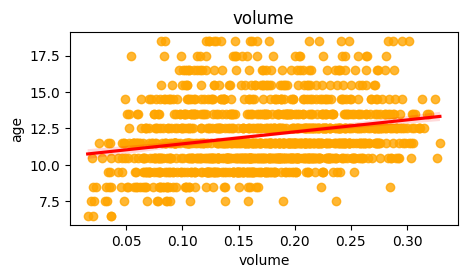

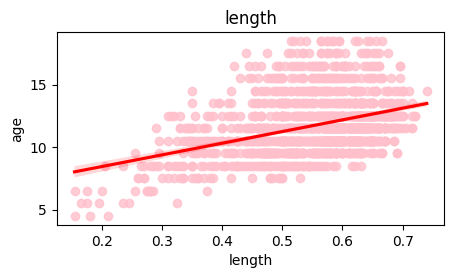

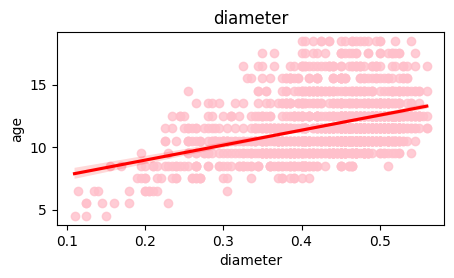

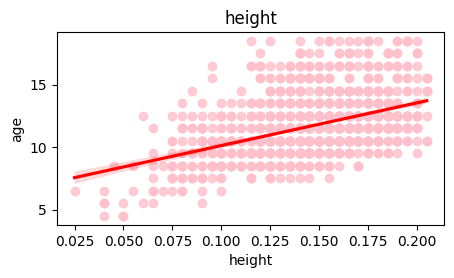

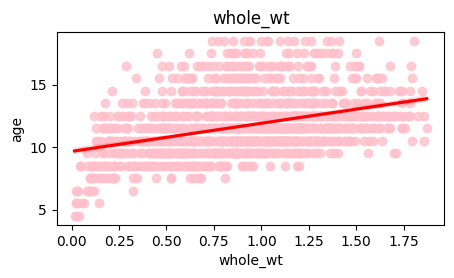

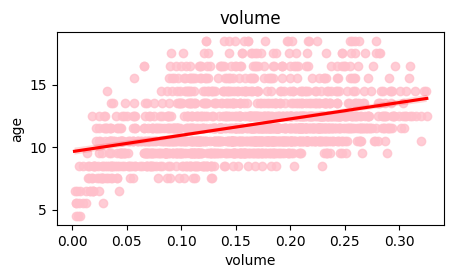

In [16]:
data_sex1 = data_sex1[[c for c in data_sex1 if c not in ['age', 'sex_enc']] + ['age', 'sex_enc']]
for x in data_sex1.iloc[:, :-2]:
    plt.figure(figsize=(5,2.5))
    sns.regplot(data=data_sex1, x=x, y='age', scatter_kws={"color": "gray", 'marker': 'o'}, line_kws={"color": "red"})
    plt.title(x)
    plt.show()

data_sex2 = data_sex2[[c for c in data_sex2 if c not in ['age', 'sex_enc']] + ['age', 'sex_enc']]
for x in data_sex2.iloc[:, :-2]:
    plt.figure(figsize=(5,2.5))
    sns.regplot(data=data_sex2, x=x, y='age', scatter_kws={"color": "orange", 'marker': 'x'}, line_kws={"color": "red"})
    plt.title(x)
    plt.show()

data_sex3 = data_sex3[[c for c in data_sex3 if c not in ['age', 'sex_enc']] + ['age', 'sex_enc']]
for x in data_sex3.iloc[:, :-2]:
    plt.figure(figsize=(5,2.5))
    sns.regplot(data=data_sex3, x=x, y='age', scatter_kws={"color": "pink", 'marker': 's'}, line_kws={"color": "red"})
    plt.title(x)
    plt.show()

### Standard Scaler

In [17]:
from sklearn.preprocessing import StandardScaler

op_data_dd = op_data_d.drop(['length', 'diameter', 'height'], axis=1)

sc = StandardScaler()
op_data_d_sc = pd.DataFrame(sc.fit_transform(op_data_dd), columns=op_data_dd.columns)
display(op_data_d_sc.head())

data_sex1_sc = pd.DataFrame(sc.fit_transform(data_sex1), columns=data_sex1.columns)
data_sex2_sc = pd.DataFrame(sc.fit_transform(data_sex2), columns=data_sex2.columns)
data_sex3_sc = pd.DataFrame(sc.fit_transform(data_sex3), columns=data_sex3.columns)

,whole_wt,age,volume,sex_enc
0,-0.579585,2.091020,-0.876949,1.180234
1,-1.249651,-0.936737,-1.284011,1.180234
2,-0.201003,-0.179798,-0.094898,-0.013331
3,-0.574940,0.198672,-0.641473,1.180234
4,-1.297264,-0.936737,-1.372522,-1.206895


### XGB linear model

In [18]:
X = op_data_d_sc.drop('age', axis=1)
y = op_data_d_sc['age']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1111)

XGBR = XGB.XGBRegressor(booster='gblinear')

XGBR.fit(X_train, y_train)

XGBR_pred = XGBR.predict(X_test)

In [20]:
print('\nScoring the XGB Regressor:')
print("XGB Regressor's mean squared error: ", mean_squared_error(y_test, XGBR_pred))
print("XGB Regressor's mean absolute error: ", mean_absolute_error(y_test, XGBR_pred))
print("XGB Regressor's r2 score: ", r2_score(y_test, XGBR_pred))
print("XGB Regressor's explained variance_score: ", explained_variance_score(y_test, XGBR_pred), '\n')

#print("Features importances:", XGBR.get_booster().get_score(importance_type='weight'))


Scoring the XGB Regressor:
XGB Regressor's mean squared error:  0.34076720964863
XGB Regressor's mean absolute error:  0.47536002767645574
XGB Regressor's r2 score:  0.5226293179117887
XGB Regressor's explained variance_score:  0.5403413243757011 



In [21]:
NUM_OF_FOLDS = 5

XGBT_cv = XGB.XGBRegressor(booster='gblinear')
scores = cross_val_score(XGBT_cv, X, y,  scoring='r2', error_score="raise", cv=NUM_OF_FOLDS)

print(scores)
print('The average R² over all the folds is %.2f' % np.mean(scores))

[0.15864374 0.03338622 0.31764846 0.33626895 0.33292097]
The average R² over all the folds is 0.24


### XGB tree model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=321)

XGBT = XGB.XGBRegressor(booster='gbtree')

XGBT.fit(X_train, y_train)

XGBT_pred = XGBT.predict(X_test)

In [23]:
print('\nScoring the XGB Tree:')
print("XGB Regressor's mean squared error: ", mean_squared_error(y_test, XGBT_pred))
print("XGB Regressor's mean absolute error: ", mean_absolute_error(y_test, XGBT_pred))
print("XGB Regressor's r2 score: ", r2_score(y_test, XGBT_pred))
print("XGB Regressor's explained variance_score: ", explained_variance_score(y_test, XGBT_pred), '\n')

print("Features importances:", XGBT.get_booster().get_score(importance_type='weight'))


Scoring the XGB Tree:
XGB Regressor's mean squared error:  0.3999863634718539
XGB Regressor's mean absolute error:  0.5150112936877783
XGB Regressor's r2 score:  0.48329755270515273
XGB Regressor's explained variance_score:  0.5051398037143865 

Features importances: {'whole_wt': 1730.0, 'volume': 1531.0, 'sex_enc': 217.0}


In [24]:
NUM_OF_FOLDS = 5

XGBT_cv = XGB.XGBRegressor(booster='gbtree')
scores = cross_val_score(XGBT_cv, X, y,  scoring='r2', error_score="raise", cv=NUM_OF_FOLDS)

print(scores)
print('The average R² over all the folds is %.2f' % np.mean(scores))

[ 0.2188785  -0.12585465  0.29917314  0.30434384  0.27977202]
The average R² over all the folds is 0.20


### XGB linear model for Infants
The separate sex model are works best for Infants, and worse than the combined sexes model for others.

In [25]:
Xi = data_sex1_sc.drop('age', axis=1)
yi = data_sex1_sc['age']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(Xi, yi, test_size=0.01, random_state=11)

XGBR = XGB.XGBRegressor(booster='gblinear')

XGBR.fit(X_train, y_train)

XGBR_pred = XGBR.predict(X_test)

In [27]:
print('\nScoring the XGB Regressor:')
print("XGB Regressor's mean squared error: ", mean_squared_error(y_test, XGBR_pred))
print("XGB Regressor's mean absolute error: ", mean_absolute_error(y_test, XGBR_pred))
print("XGB Regressor's r2 score: ", r2_score(y_test, XGBR_pred))
print("XGB Regressor's explained variance_score: ", explained_variance_score(y_test, XGBR_pred), '\n')

#print("Features importances:", XGBR.get_booster().get_score(importance_type='weight'))


Scoring the XGB Regressor:
XGB Regressor's mean squared error:  0.20320485348311643
XGB Regressor's mean absolute error:  0.4058763409355502
XGB Regressor's r2 score:  0.7085508175590296
XGB Regressor's explained variance_score:  0.7085886165107276 



In [28]:
NUM_OF_FOLDS = 5

XGBT_cv = XGB.XGBRegressor(booster='gblinear')
scores = cross_val_score(XGBT_cv, Xi, yi,  scoring='r2', error_score="raise", cv=NUM_OF_FOLDS)

print(scores)
print('The average R² over all the folds is %.2f' % np.mean(scores))

[0.51335654 0.30695513 0.57798134 0.53310504 0.63011546]
The average R² over all the folds is 0.51


### XGB tree model for Infants

In [29]:
XGBT = XGB.XGBRegressor(booster='gbtree')

XGBT.fit(X_train, y_train)

XGBT_pred = XGBT.predict(X_test)

In [30]:
print('\nScoring the XGB Tree:')
print("XGB Regressor's mean squared error: ", mean_squared_error(y_test, XGBT_pred))
print("XGB Regressor's mean absolute error: ", mean_absolute_error(y_test, XGBT_pred))
print("XGB Regressor's r2 score: ", r2_score(y_test, XGBT_pred))
print("XGB Regressor's explained variance_score: ", explained_variance_score(y_test, XGBT_pred), '\n')

print("Features importances:", XGBT.get_booster().get_score(importance_type='weight'))


Scoring the XGB Tree:
XGB Regressor's mean squared error:  0.19705218044436656
XGB Regressor's mean absolute error:  0.39226644877764194
XGB Regressor's r2 score:  0.717375368234042
XGB Regressor's explained variance_score:  0.7195419822749105 

Features importances: {'length': 782.0, 'diameter': 457.0, 'height': 274.0, 'whole_wt': 906.0, 'volume': 687.0}


In [31]:
NUM_OF_FOLDS = 5

XGBT_cv = XGB.XGBRegressor(booster='gbtree')
scores = cross_val_score(XGBT_cv, Xi, yi,  scoring='r2', error_score="raise", cv=NUM_OF_FOLDS)

print(scores)
print('The average R² over all the folds is %.2f' % np.mean(scores))

[ 0.44337096 -0.18708385  0.43814982  0.47236259  0.39575725]
The average R² over all the folds is 0.31


### Multi-layer Perceptron Regressor model (MLPRegressor) for combined

In [32]:
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=11)

mlpr = MLPRegressor()
mlpr.fit(X_train, y_train)
display(mlpr.score(X_test, y_test))
mlpr_pred = mlpr.predict(X_test)

0.4828671523996708

In [33]:
print("XGB Regressor's mean squared error: ", mean_squared_error(y_test, mlpr_pred))
print("XGB Regressor's mean absolute error: ", mean_absolute_error(y_test, mlpr_pred))
print("XGB Regressor's r2 score: ", r2_score(y_test, mlpr_pred))
print("XGB Regressor's explained variance_score: ", explained_variance_score(y_test, mlpr_pred), '\n')

XGB Regressor's mean squared error:  0.5400904772211401
XGB Regressor's mean absolute error:  0.5683769096949038
XGB Regressor's r2 score:  0.4828671523996708
XGB Regressor's explained variance_score:  0.4942130275231499 



### Multi-layer Perceptron Regressor model (MLPRegressor) for Infants

In [34]:
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(Xi, yi, test_size=0.01, random_state=11)

mlpr = MLPRegressor()
mlpr.fit(X_train, y_train)
display(mlpr.score(X_test, y_test))
mlpr_pred = mlpr.predict(X_test)

0.7780491296748144

In [35]:
print("XGB Regressor's mean squared error: ", mean_squared_error(y_test, mlpr_pred))
print("XGB Regressor's mean absolute error: ", mean_absolute_error(y_test, mlpr_pred))
print("XGB Regressor's r2 score: ", r2_score(y_test, mlpr_pred))
print("XGB Regressor's explained variance_score: ", explained_variance_score(y_test, mlpr_pred), '\n')

XGB Regressor's mean squared error:  0.15474908423877393
XGB Regressor's mean absolute error:  0.34625801370694526
XGB Regressor's r2 score:  0.7780491296748144
XGB Regressor's explained variance_score:  0.7780540751800986 



### Gaussian Process Regressor model for combined

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1111)

gpr = GaussianProcessRegressor()
gpr.fit(X_train, y_train)
display(gpr.score(X_test, y_test))
gpr_pred = gpr.predict(X_test)

0.5171984654954418

In [37]:
print("XGB Regressor's mean squared error: ", mean_squared_error(y_test, gpr_pred))
print("XGB Regressor's mean absolute error: ", mean_absolute_error(y_test, gpr_pred))
print("XGB Regressor's r2 score: ", r2_score(y_test, gpr_pred))
print("XGB Regressor's explained variance_score: ", explained_variance_score(y_test, gpr_pred), '\n')

XGB Regressor's mean squared error:  0.34464397982612927
XGB Regressor's mean absolute error:  0.432670211396011
XGB Regressor's r2 score:  0.5171984654954418
XGB Regressor's explained variance_score:  0.5418460403218335 



## Conclusion
The best variable for predict age for abalones are their Volume, and it best works for Infant abalones.